In [42]:
import numpy as np

In [43]:
def loadDataSet(fileName):      # general function to parse tab -delimited floats
    dataMat = []                # assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) # map all elements to float()
        dataMat.append(fltLine)
    return dataMat

In [44]:
def binSplitDataSet(dataSet, feature, value):
    """
    :param dataSet: 数据集合
    :param feature: 待切分的特征
    :param value:  该特征的某个值
    :return:
    """
    # 通过数组过滤方式将上述数据集合切分得到两个子集并返回
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:]
    # np.nonzero函数是numpy中用于得到数组中非零元素的位置（数组索引）的函数。
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:] 
    return mat0,mat1

In [45]:
# test

dataSet = np.mat(np.eye(4)) # 产生一个对角矩阵
print("dataSet:",dataSet)
data0, data1 = binSplitDataSet(dataSet,1,0.5)
print("data0: ",data0)
print("data1: ",data1)

dataSet: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
data0:  [[0. 1. 0. 0.]]
data1:  [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## 回归树

In [46]:
# 生成叶结点
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

In [47]:
# test
regLeaf(dataSet)

0.25

In [48]:
# 误差估计函数
def regErr(dataSet):
    """
    :return: 总方差 = 均方差var * 样本个数
    """
    # 在给定数据上计算目标变量的平方误差
    return np.var(dataSet[:,-1]) * np.array(dataSet).shape[0]

In [49]:
# test
regErr(dataSet)

0.75

In [50]:
# 找到数据集上最佳的二元切分方式。若找不到则返回None并产生叶结点
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    """
    :param leafType: 对创建叶结点的函数的引用
    :param errType:  对总方差计算函数的引用
    :param ops:  自定义的参数元组，用于控制函数的停止时机
    :return:  最佳切分的特征和特征值
    """
    tolS = ops[0]   # 容许的误差下降值
    tolN = ops[1]   # 切分的最小样本数

    # 递归停止条件1：当前节点所有样本属于同一类；
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)

    m,n = np.array(dataSet).shape
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)    # 与新切分误差对比，检查新切分能否降低误差
    bestS = np.inf; bestIndex = 0; bestValue = 0
    for featIndex in range(n-1):    # 对每个特征
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):  # 对每个特征值
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)  # 将数据集切分两份
            if (np.array(mat0).shape[0] < tolN) or (np.array(mat1).shape[0] < tolN):
                continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:  # 如果当前误差小于当前最小误差，将当前切分设定为最佳切分并更新最小误差
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS

    # 递归停止条件二：如果切分数据集后效果提升不大
    if (S - bestS) < tolS: 
        return None, leafType(dataSet)

    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # 递归停止条件三：检查两个切分后子集的大小，若其中一个小于自定义的参数tolN，则停止
    if (np.array(mat0).shape[0] < tolN) or (np.array(mat1).shape[0] < tolN):
        return None, leafType(dataSet)

    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split

In [51]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):#assume dataSet is NumPy Mat so we can array filtering
    """
    :param leafType: 建立叶结点的函数
    :param errType:  误差计算函数
    # 回归树固定这两个参数，模型树需要修改。
    :param ops: 包含树构建所需其他参数的元组
    :return:
    """
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    # 满足停止条件返回叶结点的值
    # 如果构建的是回归树，该模型是一个常数；如果是模型树，该模型是一个线性方程
    if feat == None:
        return val

    # 不满足停止条件，创建新的字典将数据集分成两部分
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree  

In [52]:
# test
myDat1 = loadDataSet('C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch09\\ex0.txt')
myMat1 = np.mat(myDat1)
createTree(myMat1)

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.582002,
  'left': {'spInd': 1,
   'spVal': 0.797583,
   'left': 3.9871632,
   'right': 2.9836209534883724},
  'right': 1.980035071428571},
 'right': {'spInd': 1,
  'spVal': 0.197834,
  'left': 1.0289583666666666,
  'right': -0.023838155555555553}}

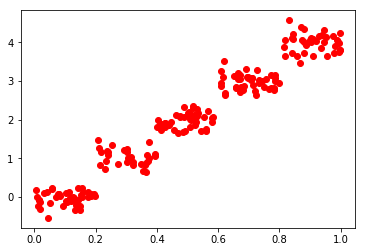

In [53]:
# 绘图测试
import matplotlib.pyplot as plt 
%matplotlib inline
plt.plot(myMat1[:,1],myMat1[:,2],'ro') 
plt.show()

In [54]:
def isTree(obj):
    """
    测试输入变量是否是一棵树，即判断当前处理的节点是否是叶节点
    :return:  布尔类型结果
    """
    return (type(obj).__name__=='dict')

In [55]:
def getMean(tree):
    """
    从上往下遍历树直到叶结点为止，如果找到两个叶结点则返回它们平均值
    :param tree:
    :return: 对数进行塌陷处理，返回树平均值
    """
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left']+tree['right'])/2.0


In [56]:
def prune(tree, testData):
    """

    :param tree: 待剪枝的树
    :param testData: 剪枝所需的测试数据
    :return:
    """
    # 测试集为空时对树塌陷处理
    if np.array(testData).shape[0] == 0:
        return getMean(tree)
    # 假设发生过拟合，采用测试数据对树进行剪枝
    if (isTree(tree['right']) or isTree(tree['left'])):#if the branches are not trees try to prune them
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] =  prune(tree['right'], rSet)
    # 如果两个分支不是子树即是叶节点，进行合并
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        errorNoMerge = np.sum(np.power(lSet[:,-1] - tree['left'],2)) + np.sum(np.power(rSet[:,-1] - tree['right'],2))
        treeMean = (tree['left']+tree['right'])/2.0
        errorMerge = np.sum(np.power(testData[:,-1] - treeMean,2))
        # 如果合并后误差比不合并小就进行合并
        if errorMerge < errorNoMerge:
            print ("merging")
            return treeMean
        else:
            return tree
    else:
        return tree

In [57]:
# test
myDat2 = loadDataSet('C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch09\\ex2.txt')
myMat2 = np.mat(myDat2)
myTree = createTree(myMat2,ops=(0,1))
# 导入测试数据
myDatTest = loadDataSet("C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch09\\ex2test.txt")
myMat2Test = np.mat(myDatTest)
# 剪枝
prune(myTree,myMat2Test)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.965969,
    'left': 92.5239915,
    'right': {'spInd': 0,
     'spVal': 0.956951,
     'left': {'spInd': 0,
      'spVal': 0.958512,
      'left': {'spInd': 0,
       'spVal': 0.960398,
       'left': 112.386764,
       'right': 123.559747},
      'right': 135.837013},
     'right': 111.2013225}},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.763328,
     'left': {'spInd': 0,
      'spVal': 0.769043,
      'left': {'spInd': 0,
       'spVal': 0.790312,
       'left': {'spInd': 0,
        'spVal': 0.806158,
        'left': {'spInd': 0,
         'spVal': 0.815215,
         'left': {'spInd': 0,
          'spVal': 0.833026,
          'left': {'spInd': 0,
           'spVal': 0.841547,
           'left': {'spInd': 0,
            'spVal': 0.841625,
            'left': {'spInd': 0,
            

## 模型树  

用树来对数据建模，除了把叶节点简单的设定为常数值外，还有一种方法是把叶节点设定为分段线性函数，这里所谓的 **分段线性** 是指模型有多个线性片段组成。  
决策树相比于其他机器学习算法的优势之一在于结果更易理解。显然，两条直线比很多节点组成一课大树更容易解释。模型树的可解释性是它优于回归树的特点之一；另外，模型树也具有更高的预测准确度。  
**该算法的关键在于误差的计算。**   
为找到最佳切分，计算误差的方法：对于给定的数据集，应该先用线性的模型来对它进行拟合，然后计算真实的目标值与模型预测值间的差值。最后将这些差值的平方求和就得到所需的误差。

In [58]:
def linearSolve(dataSet):  
    """"
    将数据集格式化成目标变量Y和自变量X
    X和Y用于执行简单的线性回归
    """
    m,n = np.array(dataSet).shape
    # 将X和Y中的数据格式化
    X = np.mat(np.ones((m,n))); Y = np.mat(np.ones((m,1)))#create a copy of data with 1 in 0th postion and strip out Y
    X[:,1:n] = dataSet[:,0:n-1]; Y = dataSet[:,-1]
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

In [59]:
def modelLeaf(dataSet):#create linear model and return coeficients
    """
    当数据不再需要切分的时候负责生成叶节点的模型
    :param dataSet:
    :return: 回归系数
    """
    ws,X,Y = linearSolve(dataSet)
    return ws

In [60]:
def modelErr(dataSet):
    """
    在给定的数据集上计算误差，被ChooseBestSplit()调用找到最佳的切分
    :param dataSet:
    :return:  yHat和Y之间的平方误差
    """
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return np.sum(np.power(Y - yHat,2))

In [61]:
# test
createTree(myMat2,modelLeaf,modelErr,(1,10))

{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.790312,
   'left': {'spInd': 0,
    'spVal': 0.841547,
    'left': {'spInd': 0, 'spVal': 0.910975, 'left': matrix([[-85.38134691],
             [195.2916547 ]]), 'right': matrix([[-198.60707966],
             [ 335.8875464 ]])},
    'right': matrix([[-413.78611049],
            [ 618.92243507]])},
   'right': matrix([[-358.95313076],
           [ 589.03437394]])},
  'right': {'spInd': 0,
   'spVal': 0.613004,
   'left': {'spInd': 0, 'spVal': 0.666452, 'left': matrix([[-37.38215781],
            [209.4219232 ]]), 'right': matrix([[-259.91915006],
            [ 565.77696463]])},
   'right': {'spInd': 0, 'spVal': 0.549814, 'left': matrix([[-212.66006427],
            [ 557.78748581]]), 'right': matrix([[ 28.11573016],
            [146.92675371]])}}},
 'right': {'spInd': 0,
  'spVal': 0.382037,
  'left': {'spInd': 0, 'spVal': 0.446196, 'left': matrix([[-314.69568607],
          

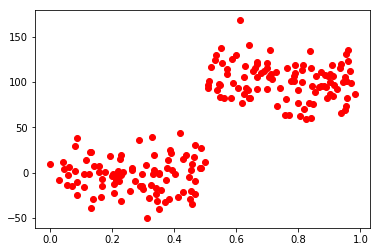

In [62]:
plt.plot(myMat2[:,0],myMat2[:,1],'ro') 
plt.show()

## 树回归与标准回归的比较

首先给出一些函数，它们可以在树构建好的情况下对给定的输入进行预测，之后利用这些函数计算三种回归模型的测试误差。

In [76]:
def regTreeEval(model, inDat):
    return float(model)

In [91]:
def modelTreeEval(model, inDat):
    n = np.array(inDat).shape[1]
    X = np.mat(np.ones((1,n+1)))
    X[:,1:n]=inDat
    return float(X*model)

In [92]:
def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree):
        return modelEval(tree, inData)
    if inData[tree['spInd']]>tree['spVal']:
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)

In [93]:
def createForeCast(tree, testData, modelEval=regTreeEval):
    # 以向量形式返回一组预测值
    m=len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, np.mat(testData[i]), modelEval)
    return yHat

In [94]:
# 预测

In [95]:
# 利用数据创建一颗回归树
trainMat = np.mat(loadDataSet('C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch09\\bikeSpeedVsIq_test.txt'))
trainMat = np.mat(loadDataSet('C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch09\\bikeSpeedVsIq_train.txt'))
myTree = createTree(trainMat,ops=(1,20))
yHat = createForeCast(myTree,testMat[:,0])
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]


0.9578326255876831

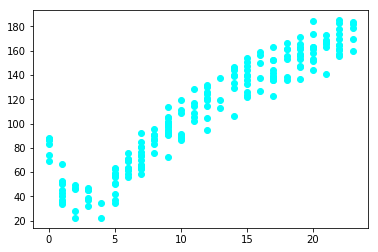

In [96]:
# 可视化数据
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(np.array(trainMat)[:,0],np.array(trainMat)[:,1],c='cyan',marker='o')
plt.show()

In [98]:
# 再创建一棵模型树
myTree = createTree(trainMat,modelLeaf,modelErr,(1,20))
myTree

{'spInd': 0,
 'spVal': 4.0,
 'left': {'spInd': 0,
  'spVal': 12.0,
  'left': {'spInd': 0,
   'spVal': 16.0,
   'left': {'spInd': 0, 'spVal': 20.0, 'left': matrix([[47.58621512],
            [ 5.51066299]]), 'right': matrix([[37.54851927],
            [ 6.23298637]])},
   'right': matrix([[43.41251481],
           [ 6.37966738]])},
  'right': {'spInd': 0, 'spVal': 9.0, 'left': matrix([[-2.87684083],
           [10.20804482]]), 'right': {'spInd': 0,
    'spVal': 6.0,
    'left': matrix([[-11.84548851],
            [ 12.12382261]]),
    'right': matrix([[-17.21714265],
            [ 13.72153115]])}}},
 'right': matrix([[ 68.87014372],
         [-11.78556471]])}

In [101]:
yHat = createForeCast(myTree,testMat[:,0],modelTreeEval)
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.38638377117105205

In [102]:
ws,X,Y = linearSolve(trainMat)
ws

matrix([[37.58916794],
        [ 6.18978355]])

为得到测试集上所有的yHat预测值，在测试集上循环进行：

In [103]:
for i in range(testMat.shape[0]):
    yHat[i] = testMat[i,0] * ws[1,0]+ws[0,0]

In [104]:
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.9393087674724667

树回归在预测复杂数据时比简单的线性模型更有效